<h1><center><font size="6">Modeling, Feature Selection and Notebook</font></center></h1>

# <a id='0'>Contents</a>

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>Modeling with Original Features</a>  
    - <a href='#21'>Logistic Regression</a>
    - <a href='#22'>Random Forest Classifier</a>
    - <a href='#23'>Decision Tree Classifier</a>
    - <a href='#24'>K-Nearest Neighbors</a>
    - <a href='#25'>Gaussian Naive Bayes Classifier</a>
    - <a href='#26'>Linear Discriminant Analysis</a>
    - <a href='#27'>AdaBoost Classifier</a>
    - <a href='#28'>Gradient Boosting Classifier</a>
    - <a href='#29'>XGBoost Classifier</a>
- <a href='#3'>Modeling with Engineered Features</a>
- <a href='#4'>Feature Selection</a>
    - <a href='#41'>Decision Tree Feature Importance</a>
    - <a href='#41'>Random Forest Feature Importance</a>
    - <a href='#41'>Recursive Feature Elimination with Cross-Validation</a>
- <a href='#4'>Addressing Class Imbalance</a>  
- <a href='#5'>Modeling with Hyperparameter Tuning</a>  
- <a href='#5'>Final Analysis</a>
- <a href='#6'>Feature Engineering</a>  

# <a id='1'>Importing Packages</a>

In [1]:
import numpy as np 
import pandas as pd
import re
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools
 
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score, classification_report, plot_confusion_matrix, auc, mean_squared_error, confusion_matrix, balanced_accuracy_score
from sklearn.preprocessing import StandardScaler

from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier, EasyEnsembleClassifier, RUSBoostClassifier
from imblearn.metrics import geometric_mean_score

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

%reload_ext autoreload
%autoreload 2

from utils import *

plt.style.use("fivethirtyeight")
sns.set_theme(style="darkgrid", font='serif', context='poster')

# <a id='1'>Evaluation Metrics</a>

## <a id='11'>Accuracy</a>

- It measures how many observations, both positive and negative, were correctly classified.

- You shouldn’t use accuracy on imbalanced problems. Then, it is easy to get a high accuracy score by simply classifying all observations as the majority class.

- Since accuracy score is calculated on the predicted classes (not prediction scores) we need to apply a certain threshold before computing it. The obvious choice is the threshold of 0.5 but it can be suboptimal.

- So, when does it make sense to use it? 

    - When your problem is balanced using accuracy is usually a good start. An additional benefit is that it is really easy to explain it to non-technical stakeholders in your project,
    - When every class is equally important to you.


## <a id='12'>F1 Score</a>

- actually a special case of the more general function F beta

- When choosing beta in your F-beta score the more you care about recall over precision the higher beta you should choose. For example, with F1 score we care equally about recall and precision with F2 score, recall is twice as important to us.

- With 0<beta<1 we care more about precision and so the higher the threshold the higher the F beta score. When beta>1 our optimal threshold moves toward lower thresholds and with beta=1 it is somewhere in the middle.

- It is important to remember that F1 score is calculated from Precision and Recall which, in turn, are calculated on the predicted classes (not prediction scores).

- WHen to use:
    - Pretty much in every binary classification problem where you care more about the positive class. It is my go-to metric when working on those problems. 
    - It can be easily explained to business stakeholders which in many cases can be a deciding factor. Always remember, machine learning is just a tool to solve a business problem. 




## ROC AUC Score

- It is a chart that visualizes the tradeoff between true positive rate (TPR) and false positive rate (FPR). Basically, for every threshold, we calculate TPR and FPR and plot it on one chart.

- Alternatively, it can be shown that ROC AUC score is equivalent to calculating the rank correlation between predictions and targets. From an interpretation standpoint, it is more useful because it tells us that this metric shows how good at ranking predictions your model is. It tells you what is the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance.

- When to Use:
    - You should use it when you ultimately care about ranking predictions and not necessarily about outputting well-calibrated probabilities.
    - You should not use it when your data is heavily imbalanced. The intuition is the following: false positive rate for highly imbalanced datasets is pulled down due to a large number of true negatives.
    - You should use it when you care equally about positive and negative classes. It naturally extends the imbalanced data discussion from the last section. If we care about true negatives as much as we care about true positives then it totally makes sense to use ROC AUC.

## Average Precision

- You can use this plot to make an educated decision when it comes to the classic precision/recall dilemma. Obviously, the higher the recall the lower the precision. Knowing at which recall your precision starts to fall fast can help you choose the threshold and deliver a better model.

- We can see that for the negative class we maintain high precision and high recall almost throughout the entire range of thresholds. For the positive class precision is starting to fall as soon as we are recalling 0.2 of true positives and by the time we hit 0.8, it decreases to around 0.7.

- Similarly to ROC AUC score you can calculate the Area Under the Precision-Recall Curve to get one number that describes model performance.

- You can also think of PR AUC as the average of precision scores calculated for each recall threshold. You can also adjust this definition to suit your business needs by choosing/clipping recall thresholds if needed.

- When to use:

    - when you want to communicate precision/recall decision to other stakeholders
    - when you want to choose the threshold that fits the business problem.
    - when your data is heavily imbalanced.  
    
- The intuition is the following: since PR AUC focuses mainly on the positive class (PPV and TPR) it cares less about the frequent negative class.
when you care more about positive than negative class. If you care more about the positive class and hence PPV and TPR you should go with Precision-Recall curve and PR AUC (average precision).



## Accuracy vs ROC AUC

- The first big difference is that you calculate accuracy on the predicted classes while you calculate ROC AUC on predicted scores. That means you will have to find the optimal threshold for your problem. 

- Moreover, accuracy looks at fractions of correctly assigned positive and negative classes. That means if our problem is highly imbalanced we get a really high accuracy score by simply predicting that all observations belong to the majority class.

- On the flip side, if your problem is balanced and you care about both positive and negative predictions, accuracy is a good choice because it is really simple and easy to interpret.

- Another thing to remember is that ROC AUC is especially good at ranking predictions. Because of that, if you have a problem where sorting your observations is what you care about ROC AUC is likely what you are looking for.



## F1 Score vs Accuracy

- Both of those metrics take class predictions as input so you will have to adjust the threshold regardless of which one you choose.

- Remember that F1 score is balancing precision and recall on the positive class while accuracy looks at correctly classified observations both positive and negative. That makes a big difference especially for the imbalanced problems where by default our model will be good at predicting true negatives and hence accuracy will be high. 

- However, if you care equally about true negatives and true positives then accuracy is the metric you should choose. 


## ROC AUC vs PR AUC

- What is common between ROC AUC and PR AUC is that they both look at prediction scores of classification models and not thresholded class assignments. 

- What is different however is that ROC AUC looks at a true positive rate TPR and false positive rate FPR while PR AUC looks at positive predictive value PPV and true positive rate TPR.

- Because of that if you care more about the positive class, then using PR AUC, which is more sensitive to the improvements for the positive class, is a better choice. One common scenario is a highly imbalanced dataset where the fraction of positive class, which we want to find (like in fraud detection), is small. 

- If you care equally about the positive and negative class or your dataset is quite balanced, then going with ROC AUC is a good idea.



# <a id='2'>Base Model</a>

In [2]:
train = pd.read_csv("../data/train_cleaned.csv")
validate = pd.read_csv("../data/validate_cleaned.csv")

In [3]:
train.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1785.87,2,2,1,44,0,0,0,0,0,...,798.64,845.04,979.41,107.72,178.69,107.15,107.15,178.59,33.00,0
1,5714.80,2,3,1,46,0,0,0,0,0,...,147.41,142.69,30.07,83.69,173.44,35.72,142.69,30.07,939.83,0
2,3571.75,2,2,1,47,0,0,0,0,0,...,223.95,-14.14,-14.14,238.09,0.00,223.95,0.00,0.00,0.00,1
3,6071.97,2,2,1,29,0,0,0,0,0,...,2282.45,1553.89,1571.39,79.83,89.04,92.33,60.11,67.90,75.40,0
4,5357.62,2,1,2,33,0,0,0,0,0,...,1195.07,992.95,80.76,964.62,1168.50,1195.64,993.23,80.76,6052.86,0


In [4]:
validate.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,billed4,billed5,billed6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1071.52,1,2,2,25,0,0,0,0,0,...,449.33,489.90,529.62,53.58,71.43,53.58,53.58,53.58,71.43,0
1,5357.62,2,1,2,26,0,0,0,0,0,...,3628.22,2776.71,2759.67,160.23,151.26,112.90,94.54,95.33,95.33,0
2,2500.22,2,3,1,32,0,0,0,0,0,...,2491.40,2504.19,2507.80,86.83,111.15,107.15,87.08,89.29,91.22,0
3,4643.27,1,3,2,49,0,0,0,0,0,...,603.55,401.32,248.02,57.51,64.58,250.52,0.96,250.42,157.44,0
4,1785.87,2,2,2,36,0,0,0,0,0,...,699.13,724.89,694.31,71.43,53.58,35.72,64.29,0.00,35.72,1


In [5]:
X_train = train.drop(["default"], axis=1)
y_tr = train["default"]
X_validate = validate.drop(["default"], axis=1)
y_val = validate["default"]


In [6]:
# # Grab indices of columns for creating dummy variables and create dataframe with dummy variables
# dum_feat = X_train[['gender', 'education', 'marriage']]
# dum_index = dum_feat.columns
# tr_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar'])
# tr_dum.head()

In [7]:
# dum_feat = X_validate[['gender', 'education', 'marriage']]
# dum_index = dum_feat.columns
# val_dum = pd.get_dummies(data=dum_feat, columns=dum_index, drop_first=True, prefix=['sex', 'edu', 'mar'])
# val_dum.head()

In [8]:
# X_tr_dum = X_train.drop(['gender', 'education', 'marriage'], axis=1)
# X_tr_dum = X_tr_dum.join(tr_dum, how="left")
# X_val_dum = X_validate.drop(['gender', 'education', 'marriage'], axis=1)
# X_val_dum = X_val_dum.join(val_dum, how="left")

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_tr = scaler.transform(X_train)
X_val = scaler.transform(X_validate)

## <a id='21'>Logistic Regression</a>

Training Accuracy:  0.8207142857142857
Validation Accuracy:  0.8168333333333333
Training F1 Score:  0.4603697864411639
Validation F1 Score:  0.4372759856630825
Training AUC Score:  0.7615982535285184
Validation AUC Score:  0.7613570682370628
Training Recall Score:  0.3449312714776632
Validation Recall Score:  0.32520944402132523
Training Precision Score:  0.6919431279620853
Validation Precision Score:  0.6671875
Training Average Precision Score:  0.5357662754871487
Validation Average Precision Score:  0.5130659708957399

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.34      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.8

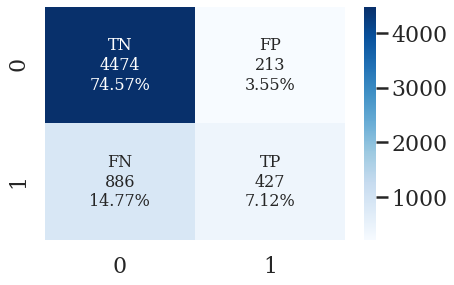

In [10]:
logreg = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr, y_tr)
y_pred_log_tr = logreg.predict(X_tr)
y_pred_log_val = logreg.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_log_tr, y_pred_log_val, logreg)

## <a id='22'>Random Forest Classifier</a>

Training Accuracy:  0.9993809523809524
Validation Accuracy:  0.8135
Training F1 Score:  0.9986035019873241
Validation F1 Score:  0.454412481716236
Training AUC Score:  0.9999982391049481
Validation AUC Score:  0.758106759618208
Training Recall Score:  0.9982817869415808
Validation Recall Score:  0.3549124143183549
Training Precision Score:  0.9989254244573393
Validation Precision Score:  0.6314363143631436
Training Average Precision Score:  0.9999935724099043
Validation Average Precision Score:  0.5131852933301093

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84     

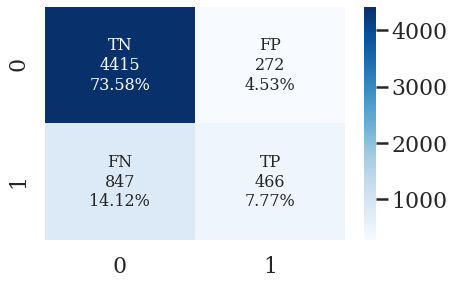

In [11]:
rfc = RandomForestClassifier().fit(X_tr, y_tr)
y_pred_rfc_tr = rfc.predict(X_tr)
y_pred_rfc_val = rfc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_rfc_tr, y_pred_rfc_val, rfc)

## <a id='13'>Decision Tree Classifier</a>

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.7276666666666667
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.3875562218890555
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6078482542580628
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.39375476009139376
Training Precision Score:  1.0
Validation Precision Score:  0.381549815498155
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.283152108292997

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0

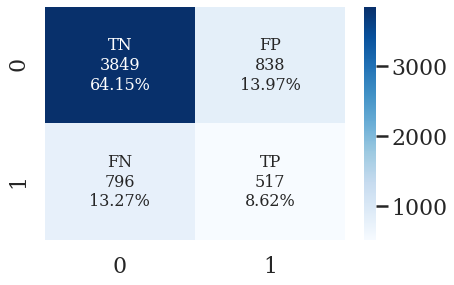

In [12]:
dtc = DecisionTreeClassifier().fit(X_tr, y_tr)
y_pred_dtc_tr = dtc.predict(X_tr)
y_pred_dtc_val = dtc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_dtc_tr, y_pred_dtc_val, dtc)

## <a id='14'>K-Nearest Neighbors</a>

Training Accuracy:  0.843047619047619
Validation Accuracy:  0.795
Training F1 Score:  0.573829842254978
Validation F1 Score:  0.4409090909090909
Training AUC Score:  0.8808282078146316
Validation AUC Score:  0.7034749256219216
Training Recall Score:  0.47658934707903783
Validation Recall Score:  0.3693830921553694
Training Precision Score:  0.7209226770630279
Validation Precision Score:  0.5467869222096956
Training Average Precision Score:  0.6406080686603904
Validation Average Precision Score:  0.4197396446674167

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16344
           1       0.72      0.48      0.57      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.71      0.74     21000
weighted avg       0.83      0.84      0.83     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84     

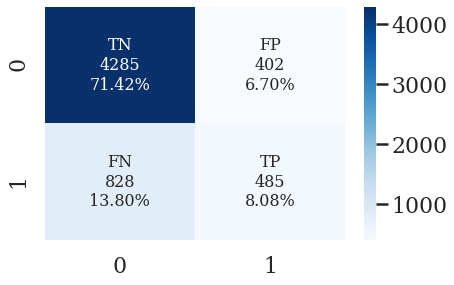

In [13]:
knn = KNeighborsClassifier().fit(X_tr, y_tr)
y_pred_knn_tr = knn.predict(X_tr)
y_pred_knn_val = knn.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_knn_tr, y_pred_knn_val, knn)

## <a id='15'>Gaussian Naive Bayes Classifier</a>

Training Accuracy:  0.7695238095238095
Validation Accuracy:  0.7656666666666667
Training F1 Score:  0.520126908586159
Validation F1 Score:  0.5097629009762901
Training AUC Score:  0.7484319229562684
Validation AUC Score:  0.7458567400781699
Training Recall Score:  0.5633591065292096
Validation Recall Score:  0.5567402894135567
Training Precision Score:  0.4830570902394107
Validation Precision Score:  0.470096463022508
Training Average Precision Score:  0.5028264895403012
Validation Average Precision Score:  0.48341103710889494

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     16344
           1       0.48      0.56      0.52      4656

    accuracy                           0.77     21000
   macro avg       0.68      0.70      0.68     21000
weighted avg       0.78      0.77      0.78     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0   

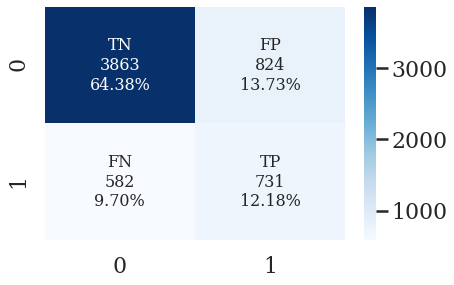

In [14]:
gnb = GaussianNB().fit(X_tr, y_tr)
y_pred_gnb_tr = gnb.predict(X_tr)
y_pred_gnb_val = gnb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gnb_tr, y_pred_gnb_val, gnb)

## <a id='17'>Linear Discriminant Analysis</a>

Training Accuracy:  0.8215714285714286
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.4799444829979181
Validation F1 Score:  0.4643564356435644
Training AUC Score:  0.7601189045697907
Validation AUC Score:  0.7575676820607501
Training Recall Score:  0.3713487972508591
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.6783052177324441
Validation Precision Score:  0.6633663366336634
Training Average Precision Score:  0.5343333116183251
Validation Average Precision Score:  0.5117838827258787

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.68      0.37      0.48      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.66      0.69     21000
weighted avg       0.81      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

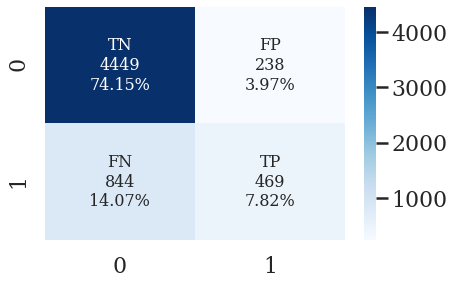

In [15]:
lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
y_pred_lda_tr = lda.predict(X_tr)
y_pred_lda_val = lda.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_lda_tr, y_pred_lda_val, lda)

## <a id='16'>AdaBoost Classifier</a>

Training Accuracy:  0.819952380952381
Validation Accuracy:  0.8153333333333334
Training F1 Score:  0.4511540136449411
Validation F1 Score:  0.4235171696149844
Training AUC Score:  0.7873281037904132
Validation AUC Score:  0.7762876885085563
Training Recall Score:  0.3337628865979381
Validation Recall Score:  0.30997715156131
Training Precision Score:  0.6959247648902821
Validation Precision Score:  0.6683087027914614
Training Average Precision Score:  0.5585736608944247
Validation Average Precision Score:  0.5247647859929081

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.70      0.33      0.45      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0     

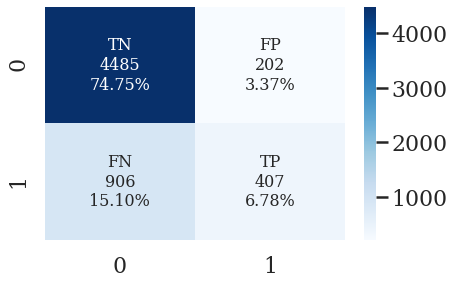

In [16]:
abc = AdaBoostClassifier().fit(X_tr, y_tr)
y_pred_abc_tr = abc.predict(X_tr)
y_pred_abc_val = abc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_abc_tr, y_pred_abc_val, abc)

## <a id='18'> Gradient Boosting Classifier</a>

Training Accuracy:  0.8287142857142857
Validation Accuracy:  0.8198333333333333
Training F1 Score:  0.5039304923458833
Validation F1 Score:  0.4645864289252105
Training AUC Score:  0.8093206777017491
Validation AUC Score:  0.7813297495576477
Training Recall Score:  0.39239690721649484
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.7040462427745665
Validation Precision Score:  0.6643059490084986
Training Average Precision Score:  0.6080316518725907
Validation Average Precision Score:  0.5478899108014791

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.70      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.81      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

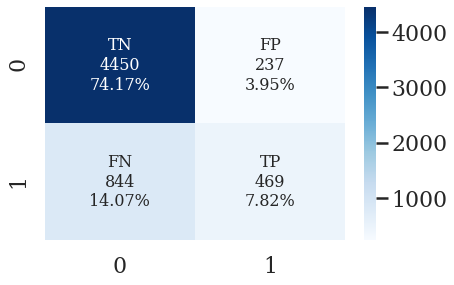

In [17]:
gbc = GradientBoostingClassifier().fit(X_tr, y_tr)
y_pred_gbc_tr = gbc.predict(X_tr)
y_pred_gbc_val = gbc.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_gbc_tr, y_pred_gbc_val, gbc)

## <a id='19'>XGBoost Classifier</a>

[12:20:05] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.891095238095238
Validation Accuracy:  0.8143333333333334
Training F1 Score:  0.6986427724337858
Validation F1 Score:  0.46493756003842457
Training AUC Score:  0.9490677926723217
Validation AUC Score:  0.7631011283498572
Training Recall Score:  0.569372852233677
Validation Recall Score:  0.3686214775323686
Training Precision Score:  0.9038527105352882
Validation Precision Score:  0.6293888166449935
Training Average Precision Score:  0.8672532450149335
Validation Average Precision Score:  0.5219345828970757

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16344
           1 

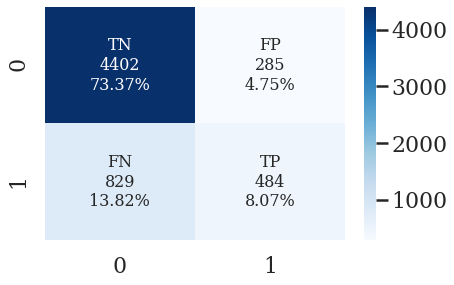

In [18]:
xgb = XGBClassifier().fit(X_tr, y_tr)
y_pred_xgb_tr = xgb.predict(X_tr)
y_pred_xgb_val = xgb.predict(X_val)
get_metrics(X_tr, y_tr, X_val, y_val, y_pred_xgb_tr, y_pred_xgb_val, xgb)

In [ ]:
model =  pd.DataFrame([[accuracy_score(y_tr, y_pred_tr), 
                        accuracy_score(y_val, y_pred_val),
                        f1_score(y_tr, y_pred_tr),
                        f1_score(y_val, y_pred_val)
    au_tr = auc(X_tr, y_tr, model)
    au_val = auc(X_val, y_val, model)
    rc_tr = recall_score(y_tr, y_pred_tr)
    rc_val = recall_score(y_val, y_pred_val)
    pr_tr = precision_score(y_tr, y_pred_tr)
    pr_val = precision_score(y_val, y_pred_val)
    aps_tr = aps(X_tr, y_tr, model)
    aps_val = aps(X_val, y_val, model),
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score','ROC'])
model_results = model_results.append(model, ignore_index = True)
model_results

# <a id='2'>Modeling with Engineered Features</a>

In [40]:
train2 = pd.read_csv("../data/train_feature.csv")
validate2 = pd.read_csv("../data/validate_feature.csv")

In [41]:
train2.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,avail4,avail3,avail2,avail1,avg_av,pperb1,pperb2,pperb3,pperb4,pperb5
0,1784.92,2,2,1,44,0,0,0,0,0,...,0.552798,0.285940,0.161878,0.088441,0.344577,0.071973,0.140129,0.134174,0.126807,0.182341
1,5711.74,2,3,1,46,0,0,0,0,0,...,0.974206,0.969650,0.985388,0.844350,0.957227,1.002157,1.000000,0.242313,1.000000,1.000000
2,3569.84,2,2,1,47,0,0,0,0,0,...,0.937300,1.000000,0.933339,0.933339,0.968650,1.000000,0.000000,1.000000,-0.000000,-0.000000
3,6068.72,2,2,1,29,0,0,0,0,0,...,0.624100,0.627547,0.631912,0.534759,0.650602,0.035719,0.039375,0.040452,0.038685,0.043208
4,5354.75,2,1,2,33,0,0,0,0,0,...,0.776940,0.781986,0.821021,0.837380,0.836154,1.005968,1.000394,1.000477,1.000292,1.000000


In [42]:
validate2.head()

,limit,gender,education,marriage,age,behind1,behind2,behind3,behind4,behind5,...,avail4,avail3,avail2,avail1,avg_av,pperb1,pperb2,pperb3,pperb4,pperb5
0,1070.95,1,2,2,25,0,0,0,0,0,...,0.580662,0.613969,0.664597,0.704533,0.602048,0.149081,0.172706,0.119241,0.109366,0.101164
1,5354.75,2,1,2,26,0,0,0,0,0,...,0.322794,0.222106,0.162327,0.088426,0.293714,0.035701,0.036294,0.031117,0.034048,0.034544
2,2498.88,2,3,1,32,0,0,0,0,0,...,0.003526,0.020997,0.013142,-0.001745,0.005217,0.035190,0.045409,0.043011,0.034772,0.035608
3,4640.79,1,3,2,49,0,0,0,0,0,...,0.870016,0.875601,0.854184,0.840939,0.883482,0.084927,0.111794,0.415082,0.002393,1.009641
4,1784.92,2,2,2,36,0,0,0,0,0,...,0.608520,0.152780,0.047302,-0.884555,0.188228,0.041988,0.035412,0.051091,0.088696,0.000000


In [43]:
X_train2 = train2.drop(["default"], axis=1)
y_tr = train2["default"]
X_validate2 = validate2.drop(["default"], axis=1)
y_val = validate2["default"]

In [44]:
scaler = StandardScaler()
scaler.fit(X_train2)
X_tr2 = scaler.transform(X_train2)
X_val2 = scaler.transform(X_validate2)

Training Accuracy:  0.8209047619047619
Validation Accuracy:  0.8163333333333334
Training F1 Score:  0.46047912781523453
Validation F1 Score:  0.4325437693099896
Training AUC Score:  0.7624345078450766
Validation AUC Score:  0.7559815672036752
Training Recall Score:  0.3447164948453608
Validation Recall Score:  0.31987814166031986
Training Precision Score:  0.693304535637149
Validation Precision Score:  0.6677265500794912
Training Average Precision Score:  0.536654359570969
Validation Average Precision Score:  0.5090781483592715

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     16344
           1       0.69      0.34      0.46      4656

    accuracy                           0.82     21000
   macro avg       0.77      0.65      0.68     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0  

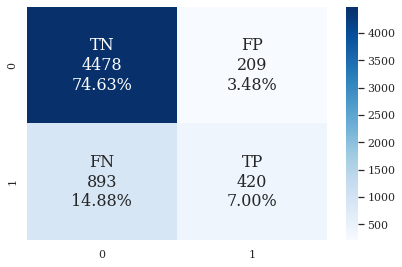

In [45]:
logreg2 = LogisticRegression(solver="liblinear", random_state=42).fit(X_tr2, y_tr)
y_pred_log_tr2 = logreg2.predict(X_tr2)
y_pred_log_val2 = logreg2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_log_tr2, y_pred_log_val2, logreg2)

Training Accuracy:  0.842
Validation Accuracy:  0.7925
Training F1 Score:  0.5688669438669439
Validation F1 Score:  0.42968392120934495
Training AUC Score:  0.8815190043152967
Validation AUC Score:  0.701184475671312
Training Recall Score:  0.47014604810996563
Validation Recall Score:  0.3571972581873572
Training Precision Score:  0.7200657894736842
Validation Precision Score:  0.539080459770115
Training Average Precision Score:  0.6365374339812295
Validation Average Precision Score:  0.4069967296752565

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.90     16344
           1       0.72      0.47      0.57      4656

    accuracy                           0.84     21000
   macro avg       0.79      0.71      0.74     21000
weighted avg       0.83      0.84      0.83     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.91      

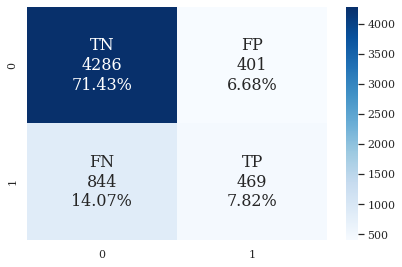

In [46]:
knn2 = KNeighborsClassifier().fit(X_tr2, y_tr)
y_pred_knn_tr2 = knn2.predict(X_tr2)
y_pred_knn_val2 = knn2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_knn_tr2, y_pred_knn_val2, knn2)

Training Accuracy:  0.27214285714285713
Validation Accuracy:  0.282
Training F1 Score:  0.3711687991113671
Validation F1 Score:  0.3752900232018561
Training AUC Score:  0.7288206967824926
Validation AUC Score:  0.7285441038564804
Training Recall Score:  0.9688573883161512
Validation Recall Score:  0.9855293221629855
Training Precision Score:  0.22955574779909418
Validation Precision Score:  0.23177503134515492
Training Average Precision Score:  0.48399137983137913
Validation Average Precision Score:  0.4722588011423

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.07      0.14     16344
           1       0.23      0.97      0.37      4656

    accuracy                           0.27     21000
   macro avg       0.56      0.52      0.25     21000
weighted avg       0.75      0.27      0.19     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.95   

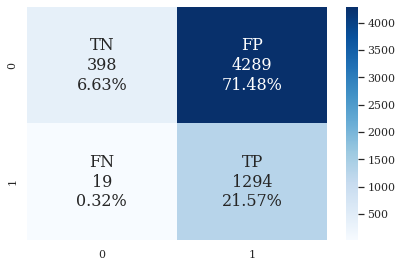

In [47]:
gnb2 = GaussianNB().fit(X_tr2, y_tr)
y_pred_gnb_tr2 = gnb2.predict(X_tr2)
y_pred_gnb_val2 = gnb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gnb_tr2, y_pred_gnb_val2, gnb2)

Training Accuracy:  0.8196666666666667
Validation Accuracy:  0.8166666666666667
Training F1 Score:  0.44996368917937546
Validation F1 Score:  0.4312306101344364
Training AUC Score:  0.7930457234534821
Validation AUC Score:  0.7743861706253998
Training Recall Score:  0.3326890034364261
Validation Recall Score:  0.3175932977913176
Training Precision Score:  0.6949304620906236
Validation Precision Score:  0.6714975845410628
Training Average Precision Score:  0.5631413361837274
Validation Average Precision Score:  0.5246419073439884

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     16344
           1       0.69      0.33      0.45      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.65      0.67     21000
weighted avg       0.80      0.82      0.79     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0 

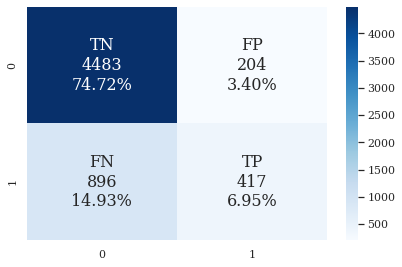

In [48]:
abc2 = AdaBoostClassifier().fit(X_tr2, y_tr)
y_pred_abc_tr2 = abc2.predict(X_tr2)
y_pred_abc_val2 = abc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_abc_tr2, y_pred_abc_val2, abc2)

Training Accuracy:  0.8211904761904761
Validation Accuracy:  0.8196666666666667
Training F1 Score:  0.47984485385787495
Validation F1 Score:  0.4632936507936508
Training AUC Score:  0.7603052309200976
Validation AUC Score:  0.7512464594344747
Training Recall Score:  0.37199312714776633
Validation Recall Score:  0.3556740289413557
Training Precision Score:  0.6757705813499805
Validation Precision Score:  0.6642958748221907
Training Average Precision Score:  0.5346639484754171
Validation Average Precision Score:  0.5075309714254697

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.95      0.89     16344
           1       0.68      0.37      0.48      4656

    accuracy                           0.82     21000
   macro avg       0.76      0.66      0.69     21000
weighted avg       0.80      0.82      0.80     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0

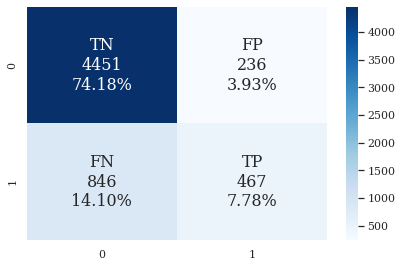

In [49]:
lda2 = LinearDiscriminantAnalysis().fit(X_tr2, y_tr)
y_pred_lda_tr2 = lda2.predict(X_tr2)
y_pred_lda_val2 = lda2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_lda_tr2, y_pred_lda_val2, lda2)

Training Accuracy:  0.8292857142857143
Validation Accuracy:  0.8195
Training F1 Score:  0.503256200637384
Validation F1 Score:  0.4619970193740686
Training AUC Score:  0.8135581730866273
Validation AUC Score:  0.7837783885066553
Training Recall Score:  0.3900343642611684
Validation Recall Score:  0.3541507996953541
Training Precision Score:  0.7090980085903944
Validation Precision Score:  0.6642857142857143
Training Average Precision Score:  0.6118177347842763
Validation Average Precision Score:  0.5453634826680588

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16344
           1       0.71      0.39      0.50      4656

    accuracy                           0.83     21000
   macro avg       0.78      0.67      0.70     21000
weighted avg       0.82      0.83      0.81     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84    

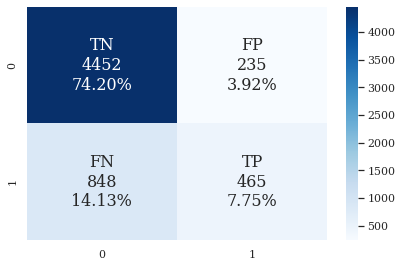

In [50]:
gbc2 = GradientBoostingClassifier().fit(X_tr2, y_tr)
y_pred_gbc_tr2 = gbc2.predict(X_tr2)
y_pred_gbc_val2 = gbc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_gbc_tr2, y_pred_gbc_val2, gbc2)

Training Accuracy:  0.9994761904761905
Validation Accuracy:  0.719
Training F1 Score:  0.9988173314697344
Validation F1 Score:  0.3842220598977356
Training AUC Score:  0.9999991983985211
Validation AUC Score:  0.6042092573144333
Training Recall Score:  0.9976374570446735
Validation Recall Score:  0.4006092916984006
Training Precision Score:  1.0
Validation Precision Score:  0.36912280701754385
Training Average Precision Score:  0.9999948438742888
Validation Average Precision Score:  0.27904069293569034

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.83      0.81      0

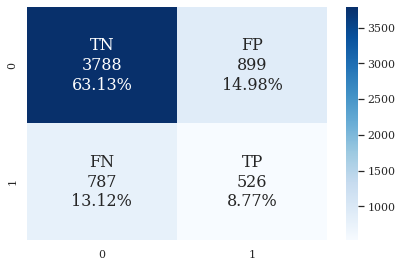

In [51]:
dtc2 = DecisionTreeClassifier().fit(X_tr2, y_tr)
y_pred_dtc_tr2 = dtc2.predict(X_tr2)
y_pred_dtc_val2 = dtc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_dtc_tr2, y_pred_dtc_val2, dtc2)

Training Accuracy:  0.9994285714285714
Validation Accuracy:  0.816
Training F1 Score:  0.9987105093488073
Validation F1 Score:  0.4604105571847507
Training AUC Score:  0.9999983048099874
Validation AUC Score:  0.7541287978562343
Training Recall Score:  0.9980670103092784
Validation Recall Score:  0.3587204874333587
Training Precision Score:  0.9993548387096775
Validation Precision Score:  0.6425648021828103
Training Average Precision Score:  0.9999937916575928
Validation Average Precision Score:  0.5130836296340442

Training Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16344
           1       1.00      1.00      1.00      4656

    accuracy                           1.00     21000
   macro avg       1.00      1.00      1.00     21000
weighted avg       1.00      1.00      1.00     21000


Validation Classification Report: 
              precision    recall  f1-score   support

           0       0.84    

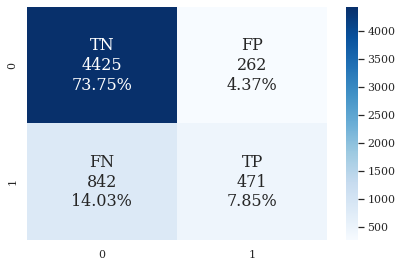

In [52]:
rfc2 = RandomForestClassifier().fit(X_tr2, y_tr)
y_pred_rfc_tr2 = rfc2.predict(X_tr2)
y_pred_rfc_val2 = rfc2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_rfc_tr2, y_pred_rfc_val2, rfc2)

[12:54:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training Accuracy:  0.8996190476190477
Validation Accuracy:  0.8126666666666666
Training F1 Score:  0.7272962483829236
Validation F1 Score:  0.4590952839268527
Training AUC Score:  0.9578797648768824
Validation AUC Score:  0.7654252960376702
Training Recall Score:  0.6037371134020618
Validation Recall Score:  0.3632901751713633
Training Precision Score:  0.9144437215354587
Validation Precision Score:  0.6235294117647059
Training Average Precision Score:  0.8865483898064123
Validation Average Precision Score:  0.5210374390704509

Training Classification Report: 
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     16344
           1

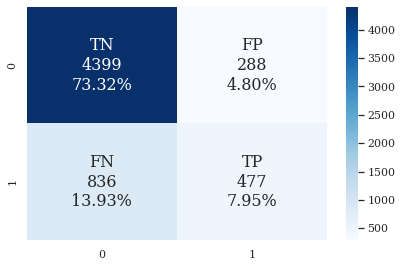

In [53]:
xgb2 = XGBClassifier().fit(X_tr2, y_tr)
y_pred_xgb_tr2 = xgb2.predict(X_tr2)
y_pred_xgb_val2 = xgb2.predict(X_val2)
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_xgb_tr2, y_pred_xgb_val2, xgb2)

# <a id='4'> Feature Selection</a>

## <a id='41'>Decision Tree Feature Importance</a>

In [54]:
sns.set_theme(style="darkgrid", font='serif', context='notebook')

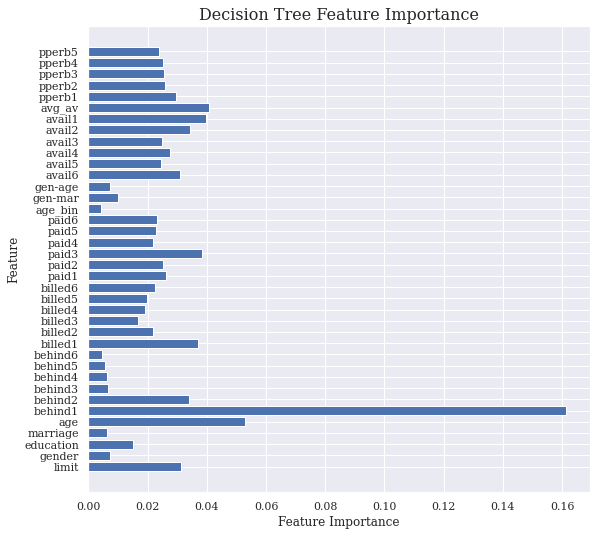

In [55]:
plot_feature_importances(X_train2, dtc2)
plt.title("Decision Tree Feature Importance", size=16)
plt.savefig('../images/dtc2_feature_importance.png')

## <a id='42'>Random Forest Feature Importance</a>

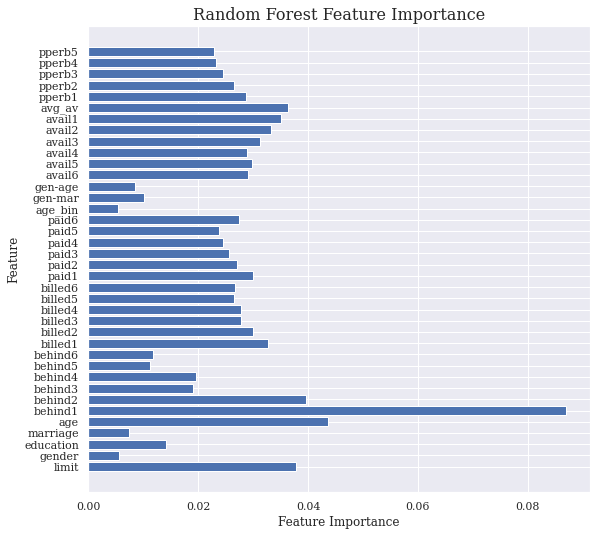

In [56]:
plot_feature_importances(X_train2, rfc2)
plt.title("Random Forest Feature Importance", size=16)
plt.savefig('../images/rf_feature_importance.png')

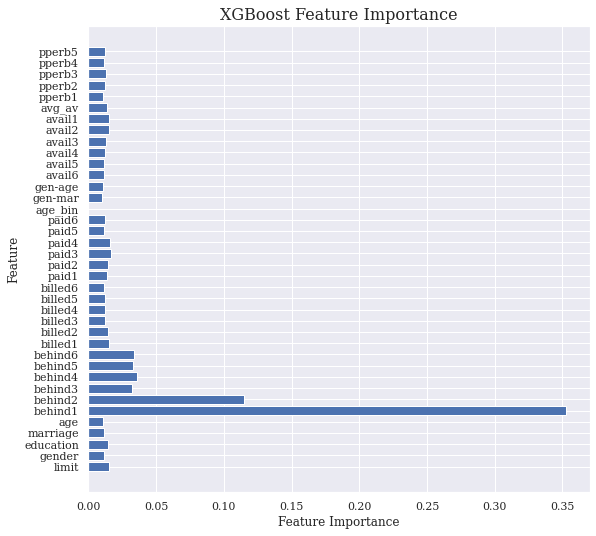

In [57]:
plot_feature_importances(X_train2, xgb2)
plt.title("XGBoost Feature Importance", size=16)
plt.savefig('../images/xgb_feature_importance.png')

Feature Ranking For Non-Discretised: [ 3 28 20 27 19  1 18  7 13 21  2 15 14  9 22 33 10  6  1 35 23 32 17 26
  8 37 11 12 29 16  4  5 34 30 25 24 36 31]
Optimal number of features : 2


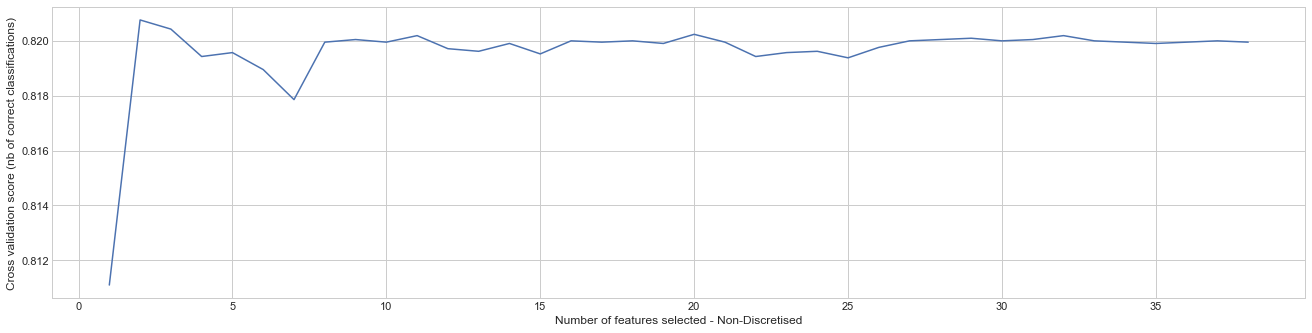

In [58]:
from sklearn.feature_selection import RFECV
rfe = RFECV(LogisticRegression(), step=1, cv=5, n_jobs=-1).fit(X_tr2, y_tr)
print("Feature Ranking For Non-Discretised: %s" % rfe.ranking_)
print("Optimal number of features : %d" % rfe.n_features_)

plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(20,5)) 
plt.xlabel("Number of features selected - Non-Discretised")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_);



In [59]:
selected = X_train2.columns[rfe.support_]
removed = X_train2.columns[~rfe.support_]
print(selected)

Index(['behind1', 'paid2'], dtype='object')


# <a id='5'>Class Imbalance</a>

In [68]:
bagging = BaggingClassifier(n_estimators=50, random_state=42).fit(X_tr2, y_tr)
balanced_bagging = BalancedBaggingClassifier(n_estimators=50, random_state=42).fit(X_tr2, y_tr)
y_pred_bc_tr = bagging.predict(X_tr2)
y_pred_bc_val = bagging.predict(X_val2)
y_pred_bbc_tr = balanced_bagging.predict(X_tr2)
y_pred_bbc_val = balanced_bagging.predict(X_val2)
print('Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'.format(balanced_accuracy_score(y_val, y_pred_bc), geometric_mean_score(y_val, y_pred_bc)))
print('Balanced Bagging classifier performance:')
print('Balanced accuracy: {:.2f} - Geometric mean {:.2f}'.format(balanced_accuracy_score(y_val, y_pred_bbc), geometric_mean_score(y_val, y_pred_bbc)))
print("")


NameError: name 'BalancedBaggingClassifier' is not defined

In [ ]:
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_bc_tr, y_pred_bc_val, bagging)

In [ ]:
get_metrics(X_tr2, y_tr, X_val2, y_val, y_pred_bbc_tr, y_pred_bbc_val, balanced_bagging)


In [73]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import TomekLinks 
print('Original dataset shape %s' % Counter(y_tr))
tl = TomekLinks()
X_train, y_res = tl.fit_resample(X_train2, y_tr)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({0: 16344, 1: 4656})
Resampled dataset shape Counter({0: 15103, 1: 4656})


In [ ]:
print('Original dataset shape %s' % Counter(y_val))
tl = TomekLinks()
